#  CS 247 : Advanced Data Mining Learning
## Homework 4 - Solution

### Due: 11:59 pm 02/13

##### Please read the Homework Guidance carefully and make sure you fulfill all the requirements.



## Problem 1: Skip-Gram (50 pts = 40 + 10)

In this problem, you are going to implement skip-gram model with negative sampling in Pytorch, apply it on the 20-newsgroup dataset, and compare your SkipGram implementation with the gensim implementation by looking at top-10 most similar words with "pittsburgh". Please note that, your SkipGram and gensim skipgram don't have to have exactly same results.

Hint:
* Running time would be long, please start early and be patient. You can reduce the number of iteration **itr_num** to 1 when you are debugging, but make sure to use **itr_num=20** to report your results.
* You may find this tutorial for the gensim library helpful if you want to get familiar with gensim: https://radimrehurek.com/gensim/auto_examples/index.html#core-tutorials-new-users-start-here

Suggestions:
* Please think about which parameters you need to define.
* Please make sure you know what shape each operation expects. Use .view() if you need to
  reshape.




In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np

In [2]:
# load dataset

from gensim.parsing.preprocessing import preprocess_string
import gensim.downloader as api

word2id = {}
id2word = {}
sent_ids  = []
sent_wds  = []

word_count = {}

itr_num = 20

dataset = api.load("20-newsgroups")  # load dataset as iterable


[==================================================] 100.1% 13.8/13.8MB downloaded


In [3]:
# data processing

for data in dataset:
    doc = data['data']
    words = preprocess_string(doc)
    for word in words:
        if word not in word_count:
            word_count[word] = 0
        word_count[word] += 1

MIN_COUNT = 5    # Only consider words whose frequency is larger than MIN_COUNT
WINDOW_SIZE = 2  # 2 words to the left, 2 to the right
for data in dataset:
    doc = data['data']
    words = preprocess_string(doc)
    sent_id = []
    sent_wd = []
    for word in words:
        if word_count[word] < MIN_COUNT:
            continue
        if word not in word2id:
            idx = len(id2word)
            word2id[word] = idx
            id2word[idx]  = word
        sent_id += [word2id[word]]
        sent_wd += [word]
        # print(sent_id, word)
    if len(sent_wd) <= WINDOW_SIZE * 2:
        continue
    sent_ids += [sent_id]
    sent_wds += [sent_wd]
    
data = []
data2 = {}
for sent in sent_ids:
    for i in range(WINDOW_SIZE, len(sent) - WINDOW_SIZE):
        context = [sent[i - WINDOW_SIZE: i] + sent[i+1: i + WINDOW_SIZE + 1]]
        target  = sent[i]
        data.append((context,target))
        

        
print("data_length:",len(data))



data_length: 2472017


In [4]:
# SkipGram model
WINDOW_SIZE = 2

def sigmoid(x):
  return (1/(1+torch.exp(-1*x)))
class SkipGram(nn.Module):

    def __init__(self, vocab_size, hidden_size = 100):
        super(SkipGram, self).__init__()
        self.u_emb = nn.Embedding(vocab_size, hidden_size)
        self.v_emb = nn.Embedding(vocab_size, hidden_size)
        self.sig = nn.Sigmoid()

    def forward(self, idx):
        return self.u_emb(idx)
    def loss(self, pos_data, neg_data):
        '''
            TODO: 
                Fill in this blank: Train the word embedding based on Skip-gram algorithm
        '''
        
        target_list = torch.LongTensor(list(list(zip(*pos_data))[1])).to(device)
     
        target_embs = self.v_emb(target_list) # target embeddings in v_emb
        target_embs1 = target_embs.repeat_interleave(2*WINDOW_SIZE,dim=0) # repeating them to later compute loss

        context_pos = torch.LongTensor(list(list(zip(*pos_data))[0])).flatten().to(device) # context positive in u_emb
        context_pos_embs = self.u_emb(context_pos)
        context_neg = torch.LongTensor(neg_data).flatten().to(device) # context negative in u_emb
        context_neg_embs = self.u_emb(context_neg)
        target_embs2 = target_embs.repeat_interleave(10*2*WINDOW_SIZE,dim=0) #target repeat for computing loss with negative context
      

        similarity_pos = torch.log(self.sig(torch.sum(context_pos_embs*target_embs1,1))) # computing similarity with positive context
        similarity_neg = torch.log(self.sig((-1*torch.sum(context_neg_embs*target_embs2,1)))) # computing similarity with negative context

        final = (torch.sum(similarity_pos) + torch.sum(similarity_neg))/len(pos_data) # computing loss
        return final



In [5]:
# apply the SkipGram model to the 20-newsgroup dataset
from tqdm.notebook import tqdm
from operator import itemgetter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



skipgram = SkipGram(len(word2id)).to(device)
optimizer = optim.Adam(skipgram.parameters(),lr=0.001)

vocabulary = {key: value for key, value in word_count.items() if value >= MIN_COUNT}
N = sum(vocabulary.values())
word_prob = {key: value/N for (key, value) in vocabulary.items()}
word_ID = list(word_prob.keys())
word_ID = [word2id[word] for word in word_ID]
neg_sample_count = 10

batch_size = 1280
l = []
neg_sum = 0
neg_sum2 = 0
neg_dic = {}
word_ids_lis = list(itemgetter(*vocabulary.keys())(word2id))
word_prob_vals = torch.Tensor(list(word_prob.values()))

for i in tqdm(range(itr_num)):
    print("iteration: ",i)
    s = 0
  
    for bid in tqdm(range(len(data) // batch_size)):

        optimizer.zero_grad()
        positive_data = data[bid * batch_size : (bid + 1) * batch_size]
     
        '''
            TODO: 
                Conduct negative sample for negative words, based on word frequency
        '''
        temp = np.random.choice(word_ids_lis,2*WINDOW_SIZE*neg_sample_count*batch_size,p = word_prob_vals,replace = True) #random words taken for negative sampling

        neg_data = temp.reshape(batch_size,2*WINDOW_SIZE*neg_sample_count) #reshaping
        loss = -1*skipgram.loss(positive_data, neg_data) #computing loss 
        loss.backward()
        s += loss
        optimizer.step() 
      

    l.append(s.item()/(len(data) // batch_size))
    print("Average Loss for the current iteration: ", l[i])
    print("-----------------------------------")

  0%|          | 0/20 [00:00<?, ?it/s]

iteration:  0


  0%|          | 0/1931 [00:00<?, ?it/s]

Average Loss for the current iteration:  109.99659341015018
-----------------------------------
iteration:  1


  0%|          | 0/1931 [00:00<?, ?it/s]

Average Loss for the current iteration:  40.5403369368203
-----------------------------------
iteration:  2


  0%|          | 0/1931 [00:00<?, ?it/s]

Average Loss for the current iteration:  24.555953845157948
-----------------------------------
iteration:  3


  0%|          | 0/1931 [00:00<?, ?it/s]

Average Loss for the current iteration:  18.71697185719834
-----------------------------------
iteration:  4


  0%|          | 0/1931 [00:00<?, ?it/s]

Average Loss for the current iteration:  15.860350045313309
-----------------------------------
iteration:  5


  0%|          | 0/1931 [00:00<?, ?it/s]

Average Loss for the current iteration:  14.235643368073537
-----------------------------------
iteration:  6


  0%|          | 0/1931 [00:00<?, ?it/s]

Average Loss for the current iteration:  13.213118203003624
-----------------------------------
iteration:  7


  0%|          | 0/1931 [00:00<?, ?it/s]

Average Loss for the current iteration:  12.527226420895909
-----------------------------------
iteration:  8


  0%|          | 0/1931 [00:00<?, ?it/s]

Average Loss for the current iteration:  12.039639030942517
-----------------------------------
iteration:  9


  0%|          | 0/1931 [00:00<?, ?it/s]

Average Loss for the current iteration:  11.674116390471259
-----------------------------------
iteration:  10


  0%|          | 0/1931 [00:00<?, ?it/s]

Average Loss for the current iteration:  11.390318528288452
-----------------------------------
iteration:  11


  0%|          | 0/1931 [00:00<?, ?it/s]

Average Loss for the current iteration:  11.162815372540134
-----------------------------------
iteration:  12


  0%|          | 0/1931 [00:00<?, ?it/s]

Average Loss for the current iteration:  10.978043274210254
-----------------------------------
iteration:  13


  0%|          | 0/1931 [00:00<?, ?it/s]

Average Loss for the current iteration:  10.822267647915588
-----------------------------------
iteration:  14


  0%|          | 0/1931 [00:00<?, ?it/s]

Average Loss for the current iteration:  10.689966945559295
-----------------------------------
iteration:  15


  0%|          | 0/1931 [00:00<?, ?it/s]

Average Loss for the current iteration:  10.575955423032108
-----------------------------------
iteration:  16


  0%|          | 0/1931 [00:00<?, ?it/s]

Average Loss for the current iteration:  10.476875040458312
-----------------------------------
iteration:  17


  0%|          | 0/1931 [00:00<?, ?it/s]

Average Loss for the current iteration:  10.390616908337648
-----------------------------------
iteration:  18


  0%|          | 0/1931 [00:00<?, ?it/s]

Average Loss for the current iteration:  10.314203294924909
-----------------------------------
iteration:  19


  0%|          | 0/1931 [00:00<?, ?it/s]

Average Loss for the current iteration:  10.24322222132315
-----------------------------------


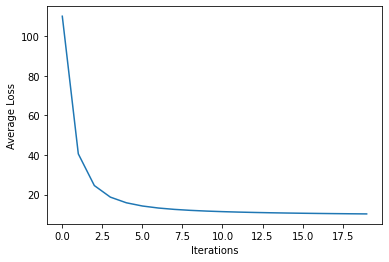

In [6]:
# visualize average loss

import matplotlib.pyplot as plt

plt.plot(l)
plt.ylabel('Average Loss')
plt.xlabel('Iterations')
plt.show()

In [7]:
# Get top-10 most similar words with "pittsburgh" using your own SkipGram model

word_embs  = skipgram.u_emb.weight.data
target_emb = skipgram.forward(torch.LongTensor([word2id['pittsburgh']]).to(device))
# cosine similarity
similarity = (word_embs * target_emb).sum(dim=1) / (torch.norm(word_embs, dim=1) * torch.norm(target_emb))
for idx in similarity.argsort(descending=True).cpu().numpy()[1:11]:
    print(id2word[idx], similarity[idx].item())

detroit 0.7561827898025513
usa 0.7361615300178528
boston 0.7256645560264587
pennsylvania 0.7140215635299683
chicago 0.6940212249755859
team 0.6928961873054504
game 0.691535472869873
seri 0.6873013377189636
plai 0.6838743686676025
montreal 0.6833861470222473


In [8]:
# Compare the results with standard gensim implementation
from gensim.models import Word2Vec
model = Word2Vec(sent_wds)
print(model.wv.most_similar('pittsburgh'))

[('minnesota', 0.8497098088264465), ('boston', 0.8301241993904114), ('chicago', 0.8171044588088989), ('saratoga', 0.793434739112854), ('baltimor', 0.7915589809417725), ('milwauke', 0.7850837707519531), ('miami', 0.7609813213348389), ('hall', 0.7532970309257507), ('philadelphia', 0.7477412819862366), ('montreal', 0.7427016496658325)]


## Problem 2: PageRank (50 pts)

In this problem, you are going to do some computations for the PageRank algorithm.

__Please run the code below to see the graph.__

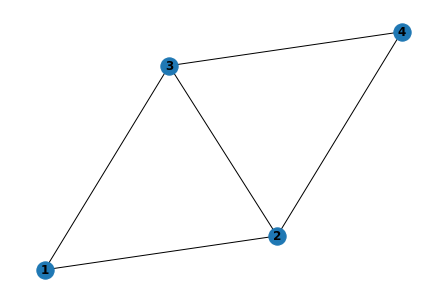

In [9]:
import networkx as nx
G = nx.Graph()
G.add_nodes_from([1,2,3,4])
G.add_edges_from([(1,2),(1,3),(2,3),(2,4),(3,4)])
nx.draw(G, with_labels=True, font_weight='bold')

### Part 1: Adjacency Matrix (10 pts)

Consider the undirected graph above. Please write down the adjacency matrix $A$ of the graph. Please write in the order of node ID.

#### Write Your Answer Here
![pic](https://drive.google.com/uc?export=view&id=1xmlz9f0z4Gnu1JOS0M7y0RhXJNHdE48N)


### Part 2: Column Stochastic Matrix (10 pts)

Please write down the column stochastic matrix $M$ for the graph. Please write in the order of node ID.

#### Write Your Answer Here
![pic](https://drive.google.com/uc?export=view&id=1nXuqY0_jn1csCx9GtZIFiMz9DLdXLb0G)

### Part 3: Random Walk Step (15 pts)

Let $r_0=(1/4,1/4,1/4,1/4)^T$ be the initial score of the random walk. Please compute the updated score $r_1$ after one random walk step. 


#### Write Your Answer Here
![pic](https://drive.google.com/uc?export=view&id=1ksFzEKpAA66ZU9wPBijTXnq36t6zumZ3)


### Part 4: Stationary Distribution (15 pts)

Let $r^{(0)}=(1/4,1/4,1/4,1/4)^T$ be the initial score of the random walk. Please compute the stationary distribution.

#### Write Your Answer Here
![pic](https://drive.google.com/uc?export=view&id=1BOYyFMsu8BBI9BLxParxPZeYjHeoFD5t)
![pic](https://drive.google.com/uc?export=view&id=1FWauPpEt7Se9gt2lyS9xdhB8ky_dxTrX)

<!-- https://drive.google.com/file/d//view?usp=sharing  -->
<!-- https://drive.google.com/file/d//view?usp=sharing -->

## Bonus Problem: PageRank (10 pts)

Prove that, for a connected undirected graph, where the adjacency matrix $A = A^T$ , the stationary distribution of random walk (without teleport) for node i is proportional to its degree $d_i$, i.e., $\pi_i = d_i/2|E|$, where $|E|$ is the total number of edges in the graph. You don't need to prove the stationary distribution is unique.

#### Write Your answer here:

![pic](https://drive.google.com/uc?export=view&id=1pvW0Ov8NFSeos5hcRbpIaGmwNCIDSGfg)
![pic](https://drive.google.com/uc?export=view&id=1pPdNrwgiU9aIAOS74PF8eKJ_IEWi03xX)